Phase 4 Project - Kaggle Competition "Natural Language Processing with Disaster Tweets"

## Business Problem

Data has been accumulated from a number of tweets, some of which are about disasters, some of which are not. By creating a model for Natural Language Processing (NLP), we can predict whether or not a given tweet is about a real disaster or not. This can benefit companies who wish to monitor twitter in the event of an emergency.

## Data Understanding

Importing necessary packages, libraries, etc.:

In [1]:
import pandas as pd 
import numpy as np 
np.random.seed(42)
import nltk
nltk.download('punkt')
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split 
from nltk import FreqDist
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nicolemichaud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading the data:

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

### Data Exploration:

###### Viewing and gaining understanding of the data, its features, number of rows, any missing values, and more so I can preprocess the data accordingly.

In [3]:
train_df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
# I won't be working with the 'location' or 'keyword' columns, so I'll just drop them
train_df = train_df.drop(columns = ['location', 'keyword'])
test_df = test_df.drop(columns = ['location', 'keyword'])
train_df.head()

id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1

In [7]:
train_df['text'].dropna(inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


In [8]:
test_df['text'].dropna(inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB


In [9]:
# Example of what is NOT a disaster tweet:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

In [10]:
# Example of what IS a disaster tweet:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

###### Visualizing what proportion of the training data are disaster tweets and non-disaster tweets:

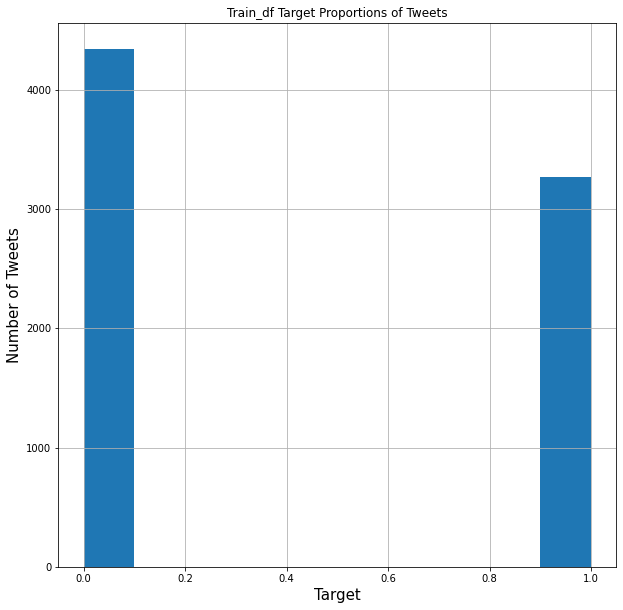

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
proportions = train_df['target'].hist()
plt.xlabel('Target',fontsize=15)
plt.ylabel('Number of Tweets',fontsize=15)
plt.title('Train_df Target Proportions of Tweets');

#fig, ax = plt.subplots(figsize=(10,10))
#cm_1 = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = baseline_tree.classes_)
#cm_1.plot(cmap=plt.cm.Greens, ax=ax)
#plt.xlabel('Prediction label',fontsize=15)
#plt.ylabel('True label',fontsize=15);

###### Calculating the probabilities of disaster and non-disaster tweets in the training data:

In [13]:
disaster_tweets = train_df[train_df['target']==1]

other_tweets = train_df[train_df['target']==0]

In [14]:
P_disasters = len(disaster_tweets) /(len(disaster_tweets)+len(other_tweets))
P_non = len(other_tweets) /(len(other_tweets)+len(disaster_tweets))
print(P_disasters)
print(P_non)

0.4296597924602653
0.5703402075397347


This tells us that tweets in train_df have a higher probability of not being about a disaster.

## Data Preparation

<b>Cleaning text data:</b> Remove urls, tags (contain @), stopwords, punctuation, etc.

In [40]:
# Creating a function to perform all these cleaning steps at once
stopwords_list = stopwords.words('english')

no_bad_chars = re.compile('[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n - ]')
no_nums = re.compile('[\d-]')

def clean_text(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    text = text.lower() 
    text = ' '.join(word for word in text.split() if word not in stopwords_list)
    return text
    

train_df_cleaned = train_df['text'].apply(clean_text)
test_df_cleaned = test_df['text'].apply(clean_text)
train_df_cleaned.head(10) 




0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked 'shelter place' notified offic...
3    people receive wildfires evacuation orders cal...
4    got sent photo ruby alaska smoke wildfires pou...
5    rockyfire update california hwy closed directi...
6    flood disaster heavy rain causes flash floodin...
7                          i'm top hill see fire woods
8    there's emergency evacuation happening buildin...
9                       i'm afraid tornado coming area
Name: text, dtype: object

In [15]:
#Performing a train-test split on the training data to see how our models perform 
#before applying them to our testing data

X = train_df.text
y = train_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

In [42]:
#Applying the text cleaning function to our data

X_train_cleaned = X_train.apply(clean_text)
X_test_cleaned = X_test.apply(clean_text)

In [19]:
***


#Creating a function to visualize the top 10 words in a frequency distribution of our data

def visualize_top_10(freq_dist, title):

    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    


In [20]:
***

train_freq_dist = FreqDist(train_df_tokenized.explode())
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for train_df")

In [21]:
***

test_freq_dist = FreqDist(test_df_tokenized.explode())
visualize_top_10(test_freq_dist, "Top 10 Word Frequency for test_df")

*** 
Many of the most common words are the same in both the training df and the test df.

In [23]:
disaster_tweets_cleaned = disaster_tweets['text'].apply(clean_text)
other_tweets_cleaned = other_tweets['text'].apply(clean_text)

In [24]:
disaster_tweets_tokenized = disaster_tweets_cleaned.apply(tokenizer.tokenize)
other_tweets_tokenized = other_tweets_cleaned.apply(tokenizer.tokenize)


In [25]:
dis_tweets_freq_dist = FreqDist(disaster_tweets_tokenized.explode())
visualize_top_10(dis_tweets_freq_dist, "Top 10 Word Frequency for disaster tweets in train_df")

In [26]:
other_tweets_freq_dist = FreqDist(other_tweets_tokenized.explode())
visualize_top_10(other_tweets_freq_dist, "Top 10 Word Frequency for non-disaster tweets in train_df")

### Building a baseline model

In [27]:
baseline_model = Pipeline([('vect', CountVectorizer(max_features=None,
                                                    tokenizer=word_tokenize,
                                                   stop_words=stopwords_list)),
                           ('clf', MultinomialNB())
              ])
baseline_model.fit(X_train_cleaned, y_train)


y_pred = baseline_model.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred, y_test, average="macro"))
print(classification_report(y_test, y_pred))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7980290172460991
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1091
           1       0.80      0.73      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.80      0.80      1904
weighted avg       0.80      0.80      0.80      1904



In [44]:
# Model with bigrams:
bigrams_model = Pipeline([('vect', CountVectorizer(max_features=None,
                                                    tokenizer=word_tokenize,
                                                   stop_words=stopwords_list,
                                                   ngram_range=(1,2))),
                           ('clf', MultinomialNB())
              ])
bigrams_model.fit(X_train_cleaned, y_train)


y_pred_bigr = bigrams_model.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred_bigr, y_test, average="macro"))
print(classification_report(y_test, y_pred_bigr))




/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7952741308160336
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1091
           1       0.79      0.73      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904



In [29]:
# model with TF-IDF Vectorizer instead of CountVectorizer

model2 = Pipeline([('vect', TfidfVectorizer(tokenizer=word_tokenize,
                                           stop_words=stopwords_list)),
                   ('clf', MultinomialNB()),
                  ])
model2.fit(X_train_cleaned, y_train)


from sklearn.metrics import classification_report
y_pred2 = model2.predict(X_test_cleaned)

print('F1 %s' % f1_score(y_pred2, y_test, average="macro"))
print(classification_report(y_test, y_pred2))

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


F1 0.7917740240719726
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1091
           1       0.84      0.67      0.74       813

    accuracy                           0.80      1904
   macro avg       0.81      0.79      0.79      1904
weighted avg       0.81      0.80      0.80      1904



In [30]:
#when stemming/lemmatizing, we are going to do the same to the stopwords, 
#so we don't want to remove them before this.

#Creating a function that cleans the text data without removing stopwords:

def clean_text_nostop(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text)
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text)
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") 
    text = text.lower() 
    return text
    
train_df_cleaned_nostop = train_df.copy()

train_df_cleaned_nostop['text'] = train_df_cleaned_nostop['text'].apply(clean_text_nostop)

X_nostop = train_df_cleaned_nostop.text
y_nostop = train_df_cleaned_nostop.target
X_train_nostop, X_test_nostop, y_train_nostop, y_test_nostop = train_test_split(X_nostop, y_nostop, test_size=0.25, random_state = 42)


In [31]:
# Stemming the text to see if it improves our model
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]
stemmed_stopwords = [stemmer.stem(word) for word in stopwords_list]

In [32]:
#Stemmed data model
stem_model = Pipeline([('vect', CountVectorizer(
                         stop_words=stemmed_stopwords,
                         tokenizer=stem_and_tokenize)),
               ('clf', MultinomialNB()),
              ])
stem_model.fit(X_train_nostop, y_train_nostop)


from sklearn.metrics import classification_report
y_pred_stem= stem_model.predict(X_test_nostop)

print('F1 %s' % f1_score(y_pred_stem, y_test_nostop, average="macro"))
print(classification_report(y_test_nostop, y_pred_stem))

F1 0.7995784912170498
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1091
           1       0.79      0.74      0.76       813

    accuracy                           0.81      1904
   macro avg       0.80      0.80      0.80      1904
weighted avg       0.81      0.81      0.80      1904



In [33]:
# Lemmatizing the text to see if it improves our model
lemmatizer = WordNetLemmatizer() 

def lem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [lemmatizer.lemmatize(token) for token in tokens]


lemm_stopwords = [lemmatizer.lemmatize(word) for word in stopwords_list]

In [34]:
# Lemmatized data model
lemm_model = Pipeline([('vect', CountVectorizer(
                         stop_words=lemm_stopwords,
                         tokenizer=lem_and_tokenize)),
                       ('clf', MultinomialNB()),
              ])
lemm_model.fit(X_train_nostop, y_train_nostop)


from sklearn.metrics import classification_report
y_lemm_pred= lemm_model.predict(X_test_nostop)

print('F1 %s' % f1_score(y_lemm_pred, y_test_nostop))
print(classification_report(y_test_nostop, y_lemm_pred))

F1 0.7612412919569347
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1091
           1       0.78      0.74      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904



#### <em>The best model so far was the stemmed model.</em>

Conducting GridSearchCV to see if tuning the hyperparameters in our best model will improve it further:

In [35]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_cleaned)
X_test_vectorized = vectorizer.transform(X_test_cleaned)



In [36]:
cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train_cleaned)
X_train_vec  = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)


X_test_vec = cv.transform(X_test_cleaned)
X_test_vec  = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)

In [37]:
#GridSearchCV
alphas = [0.5, 1.0, 1.5, 2.0, 2.5]
p_grid_NB = {'alpha': alphas, 'fit_prior' : [True, False]}
NB_cls= MultinomialNB()

grid = GridSearchCV(estimator = NB_cls, param_grid = p_grid_NB, scoring = 'f1', cv = 3)
grid.fit(X_train_vec, y_train)

GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': [0.5, 1.0, 1.5, 2.0, 2.5],
                         'fit_prior': [True, False]},
             scoring='f1')

Explanation for hyperparams:
- alpha specifies whether or not to use smoothing/ it is the additive smoothing parameter (0=No smoothing)

- class prior is the prior probability of the classes. Default is None.  If specified the priors are not adjusted according to the data.

- fit prior specifies whether to learn class prior probabilities or not. If false, a uniform prior will be used.

In [38]:
grid.best_params_

{'alpha': 2.0, 'fit_prior': True}

In [37]:
tuned_model = Pipeline([('vect', CountVectorizer(
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize,
    ngram_range = (1,3))),
                        ('clf', MultinomialNB(alpha= 2.0,fit_prior = True)),
              ])
tuned_model.fit(X_train_nostop, y_train_nostop)

y_pred_tuned= tuned_model.predict(X_test_nostop)

print('F1 %s' % f1_score(y_pred_tuned, y_test_nostop, average="macro"))
print(classification_report(y_test_nostop, y_pred_tuned))

F1 0.8015542480543345
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1091
           1       0.80      0.73      0.76       813

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



In [38]:
cnf_matrix = confusion_matrix(y_test_nostop, y_pred_tuned)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[945 146]
 [219 594]]


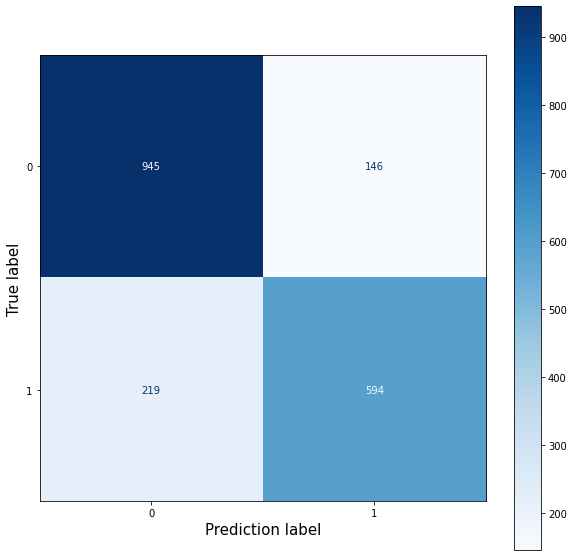

In [39]:
#CM Visualization:
fig, ax = plt.subplots(figsize=(10,10))
cm_1 = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = tuned_model.classes_)
cm_1.plot(cmap=plt.cm.Blues, ax=ax)
plt.xlabel('Prediction label',fontsize=15)
plt.ylabel('True label',fontsize=15);

This model gave 945 True Positives, 594 True Negatives, 146 False Negatives, and 219 False Positives. In this case, it would be better to have a false positive than a false negative, so this is good.

______

In [42]:
# Cleaning with POS Tagging

from nltk import pos_tag
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [43]:
stopwords_list = stopwords.words('english')

no_bad_chars = re.compile('[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n - ]')
no_nums = re.compile('[\d-]')

def clean_text_pos(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    #text = text.lower() 
    text = pos_tag(text)
    text = [(word[0], get_wordnet_pos(word[1])) for word in text]
    #text = ' '.join(word for word in text.split() if word not in stopwords_list)
    return text
    

train_df_pos = train_df.copy()

train_df_pos['pos'] = train_df_pos['text'].apply(clean_text_pos)

X_pos = train_df_pos.pos
y_pos = train_df_pos.target
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y_pos, test_size=0.25, random_state = 42)


In [67]:
train_df_pos

id keyword                                               text  \
0         1     NaN  Our Deeds are the Reason of this #earthquake M...   
1         4     NaN             Forest fire near La Ronge Sask. Canada   
2         5     NaN  All residents asked to 'shelter in place' are ...   
3         6     NaN  13,000 people receive #wildfires evacuation or...   
4         7     NaN  Just got sent this photo from Ruby #Alaska as ...   
...     ...     ...                                                ...   
7608  10869     NaN  Two giant cranes holding a bridge collapse int...   
7609  10870     NaN  @aria_ahrary @TheTawniest The out of control w...   
7610  10871     NaN  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...   
7611  10872     NaN  Police investigating after an e-bike collided ...   
7612  10873     NaN  The Latest: More Homes Razed by Northern Calif...   

      target                                                pos  
0          1  [(O, n), (u, a), (r, n), ( , n), (D, n), (e, n...  
1          1  [(F, n), (o, n), (r, v), (e, n), (s, a), (t, n...  
2          1  [(A, n), (l, n), (l, n), ( , n), (r, n), (e, n...  
3          1  [( , a), ( , n), (p, n), (e, n), (o, n), (p, n...  
4          1  [(J, n), (u, a), (s, n), (t, n), ( , n), (g, n...  
...      ...                                                ...  
7608       1  [(T, n), (w, n), (o, n), ( , n), (g, n), (i, v...  
7609       1  [( , v), (a, n), (h, n), (r, n), (a, n), (r, n...  
7610       1  [(M, n), ( , n), ( , n), ( , n), ( , n), ( , n...  
7611       1  [(P, n), (o, n), (l, v), (i, a), (c, n), (e, v...  
7612       1  [(T, n), (h, n), (e, n), ( , n), (L, n), (a, n...  

[7613 rows x 5 columns]

In [70]:
vec = CountVectorizer
X_train_pos = X_train_pos.apply(vec)
y_train_pos = y_train_pos.apply(vec)

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass input=[(' ', 'a'), (' ', 'n'), ('T', 'n'), ('h', 'n'), ('i', 'n'), ('s', 'v'), (' ', 'n'), ('m', 'v'), ('a', 'n'), ('k', 'n'), ('e', 'n'), ('s', 'n'), (' ', 'n'), ('s', 'n'), ('e', 'n'), ('n', 'a'), ('s', 'n'), ('e', 'n'), (' ', 'n'), (' ', 'n'), ('P', 'n'), ('a', 'n'), ('p', 'n'), ('e', 'n'), ('r', 'n'), (' ', 'n'), ('b', 'n'), ('e', 'v'), ('a', 'n'), ('t', 'n'), ('s', 'n'), (' ', 'n'), ('r', 'n'), ('o', 'n'), ('c', 'n'), ('k', 'n'), (' ', 'n'), ('p', 'v'), ('a', 'n'), ('p', 'n'), ('e', 'n'), ('r', 'n'), (' ', 'n'), ('c', 'v'), ('o', 'a'), ('m', 'n'), ('e', 'n'), ('s', 'n'), (' ', 'n'), ('f', 'n'), ('r', 'n'), ('o', 'n'), ('m', 'n'), (' ', 'n'), ('w', 'n'), ('o', 'n'), ('o', 'n'), ('d', 'n'), (' ', 'n'), ('s', 'n'), ('o', 'n'), (' ', 'n'), ('w', 'n'), ('o', 'n'), ('o', 'n'), ('d', 'n'), (' ', 'n'), ('s', 'n'), ('h', 'n'), ('o', 'a'), ('u', 'a'), ('l', 'n'),

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass input=[('A', 'n'), ('n', 'a'), ('t', 'n'), ('i', 'n'), (' ', 'v'), ('C', 'n'), ('o', 'n'), ('l', 'v'), ('l', 'n'), ('i', 'n'), ('s', 'v'), ('i', 'n'), ('o', 'v'), ('n', 'a'), (' ', 'n'), ('R', 'n'), ('e', 'v'), ('a', 'n'), ('r', 'n'), (' ', 'n'), (' ', 'n'), ('t', 'n'), ('e', 'n'), ('c', 'n'), ('h', 'n'), ('n', 'a'), ('o', 'n'), ('l', 'n'), ('o', 'n'), ('g', 'n'), ('y', 'n'), (' ', 'n'), (' ', 'n'), ('c', 'v'), ('o', 'a'), ('o', 'a'), ('l', 'n'), (' ', 'n'), (' ', 'n'), ('V', 'n'), ('i', 'v'), ('a', 'n'), (' ', 'a'), ('T', 'n'), ('e', 'n'), ('c', 'n'), ('h', 'n'), ('e', 'n'), ('s', 'n'), ('b', 'v'), ('a', 'n'), ('c', 'n'), ('k', 'n'), (' ', 'n'), (' ', 'n'), ('T', 'n'), ('e', 'v'), ('c', 'n'), ('h', 'n')] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.2

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass input=[(' ', 'n'), ('h', 'n'), ('e', 'n'), ('y', 'n'), (' ', 'n'), ('y', 'n'), ('o', 'n'), ('u', 'v'), (' ', 'n'), ('g', 'n'), ('u', 'a'), ('y', 'n'), ("'", 'n'), ('s', 'a'), (' ', 'n'), ('i', 'n'), (' ', 'v'), ('s', 'n'), ('t', 'n'), ('o', 'n'), ('p', 'n'), ('p', 'n'), ('e', 'n'), ('d', 'n'), (' ', 'v'), ('a', 'n'), (' ', 'a'), ('m', 'n'), ('a', 'n'), ('s', 'n'), ('s', 'v'), ('a', 'n'), ('c', 'a'), ('r', 'n'), ('e', 'n'), (' ', 'n'), ('s', 'n'), ('o', 'n'), (' ', 'n'), ('y', 'n'), ('o', 'n'), ('u', 'v'), (' ', 'n'), (' ', 'n'), (' ', 'n'), ('s', 'v'), ('e', 'a'), ('n', 'a'), ('d', 'n'), (' ', 'n'), ('t', 'n'), ('h', 'n'), ('e', 'n'), (' ', 'n'), ('c', 'v'), ('o', 'a'), ('p', 'n'), ('s', 'n'), (' ', 'n'), ('t', 'n'), ('o', 'n'), (' ', 'n'), ('m', 'n'), ('y', 'n'), (' ', 'n'), ('h', 'n'), ('o', 'n'), ('u', 'a'), ('s', 'n'), ('e', 'n'), (' ', 'n'), ('t', 'n'),

/Users/nicolemichaud/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass input=[('T', 'n'), ('h', 'n'), ('e', 'n'), (' ', 'n'), ('G', 'n'), ('u', 'v'), ('a', 'n'), ('r', 'n'), ('d', 'n'), ('i', 'v'), ('a', 'n'), ('n', 'a'), (' ', 'n'), ('v', 'n'), ('i', 'n'), ('e', 'v'), ('w', 'n'), (' ', 'n'), ('o', 'v'), ('n', 'a'), (' ', 'n'), ('t', 'n'), ('h', 'n'), ('e', 'n'), (' ', 'n'), ('H', 'n'), ('i', 'n'), ('r', 'v'), ('o', 'a'), ('s', 'n'), ('h', 'n'), ('i', 'a'), ('m', 'v'), ('a', 'n'), (' ', 'a'), ('l', 'n'), ('e', 'n'), ('g', 'v'), ('a', 'n'), ('c', 'a'), ('y', 'n'), (' ', 'n'), (' ', 'n'), ('s', 'v'), ('t', 'n'), ('i', 'n'), ('l', 'v'), ('l', 'n'), (' ', 'n'), ('i', 'n'), ('n', 'v'), (' ', 'a'), ('t', 'n'), ('h', 'n'), ('e', 'n'), (' ', 'n'), ('s', 'n'), ('h', 'v'), ('a', 'n'), ('d', 'n'), ('o', 'n'), ('w', 'n'), (' ', 'n'), ('o', 'v'), ('f', 'a'), (' ', 'n'), ('t', 'n'), ('h', 'n'), ('e', 'n'), (' ', 'n'), ('b', 'n'), ('o', 'n'),

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [65]:
mod2 = MultinomialNB(alpha= 2.0,fit_prior = True)
mod2.fit(X_train_pos, y_train_pos)


y_pred_tuned2= mod2.predict(X_test_pos)


ValueError: could not convert string to float: '@dicehateme @PuppyShogun This makes sense. Paper beats rock paper comes from wood so wood should be able to support and obliterate rock.'

In [59]:
tuned_model2 = Pipeline([('vect', CountVectorizer(
    stop_words=stemmed_stopwords,
    tokenizer=stem_and_tokenize,
    ngram_range = (1,3))),
                        ('clf', MultinomialNB(alpha= 2.0,fit_prior = True)),
              ])
tuned_model2.fit(X_train_pos, y_train_pos)


y_pred_tuned2= tuned_model2.predict(X_test_pos)

print('F1 %s' % f1_score(y_pred_tuned2, y_test_pos, average="macro"))
print(classification_report(y_test_pos, y_pred_tuned2))

ValueError: setting an array element with a sequence.

## Generating Predictions

In [43]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [44]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


Before creating predictions on the sample submission csv, I want to try it on the test_df to make sure it works:


In [45]:
def clean_text_nostop(text):
    text = no_nums.sub('', text) 
    text = re.sub("@[A-Za-z0-9]+","",text) #Remove @ sign
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) #Remove http links
    text = no_bad_chars.sub(' ', text) 
    text = text.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    text = text.lower() 
    return text
    
test_df_cleaned_nostop = test_df.copy()

test_df_cleaned_nostop['text'] = test_df_cleaned_nostop['text'].apply(clean_text_nostop)


In [46]:
test_df_cleaned_nostop

id keyword                                               text
0         0     NaN                 just happened a terrible car crash
1         2     NaN  heard about  earthquake is different cities  s...
2         3     NaN  there is a forest fire at spot pond  geese are...
3         9     NaN           apocalypse lighting   spokane  wildfires
4        11     NaN        typhoon soudelor kills  in china and taiwan
...     ...     ...                                                ...
3258  10861     NaN  earthquake safety los angeles ûò safety faste...
3259  10865     NaN  storm in ri worse than last hurricane  my city...
3260  10868     NaN                  green line derailment in chicago 
3261  10874     NaN        meg issues hazardous weather outlook  hwo  
3262  10875     NaN   cityofcalgary has activated its municipal eme...

[3263 rows x 3 columns]

In [47]:
test_df_sample = test_df_cleaned_nostop.copy()
test_df_sample['target'] = tuned_model.predict(test_df_sample['text'])

In [48]:
test_df_sample

id keyword                                               text  target
0         0     NaN                 just happened a terrible car crash       1
1         2     NaN  heard about  earthquake is different cities  s...       1
2         3     NaN  there is a forest fire at spot pond  geese are...       1
3         9     NaN           apocalypse lighting   spokane  wildfires       1
4        11     NaN        typhoon soudelor kills  in china and taiwan       1
...     ...     ...                                                ...     ...
3258  10861     NaN  earthquake safety los angeles ûò safety faste...       1
3259  10865     NaN  storm in ri worse than last hurricane  my city...       0
3260  10868     NaN                  green line derailment in chicago        1
3261  10874     NaN        meg issues hazardous weather outlook  hwo         1
3262  10875     NaN   cityofcalgary has activated its municipal eme...       1

[3263 rows x 4 columns]

In [49]:
test_df_sample['target'].value_counts()

0    2062
1    1201
Name: target, dtype: int64

This appears to have worked, so let's try it on the sample submission:

In [50]:
sample_submission["target"] = tuned_model.predict(test_df['text'])

In [51]:
sample_submission['target'].value_counts()

0    2001
1    1262
Name: target, dtype: int64

## Evaluation

Next steps:
    - could try log transformations
    - neural networks? 
    - other kinds of models such as Bert?

## Conclusion